In [30]:
from transformers import pipeline
from modules.tweet_data import read_raw_data, clean_sentiment
from modules.topics import TopicSeries, display_components

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import log_loss
import numpy as np
import pandas as pd
import spacy
import pickle
import datetime as dt
import time

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Load tweet and market data

In [9]:
# Data set contains tweets for February and March 2020
tweet_df = read_raw_data('data/tweets_reduced.csv')

es = pd.read_csv('data/spx.csv')
es.Date = pd.to_datetime(es.Date +' ' +'15:45')
es.set_index('Date', inplace=True)
date_range = es['2020-01-30':'2020-04-01'].index

Reading data


# Daily Topics

In [11]:
# Calculate daily topic models for all tweets in date range
# Functionality is in TopicSeries class in modules.topics
ts=TopicSeries()
ts.fit(tweet_df, date_range)
ts.save('topics' + '-' + str(date_range[0].date()) + '-' + str(date_range[-1].date()) + '.p')

Working on :  2020-04-01
Finished


# Features

## Topic Features

In [13]:
dates = sorted(list(ts.nmf_dict.keys()))
date_dict = {date:i for i, date in enumerate(dates)}

# Estimate reconstruction error. For a days tweets, see model from previous day. 
# Use it to transform data, calculate reconstruction error
# The feature is the ratio between the reconstruction error in the original model with the new reconstruction error
# To standarize for weekends
model_err, new_err = ts.calc_rec_error(tweet_df, date_range[1:])

Working on :  2020-04-01
Finished


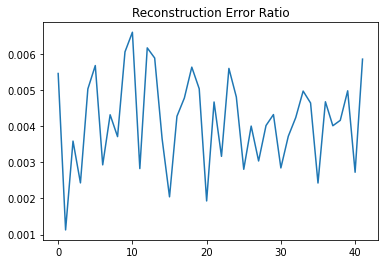

In [14]:
plt.plot(np.array(model_err) / np.array(new_err)-1)
plt.title('Reconstruction Error Ratio');

In [15]:
# Obtain top 20 words for each topic by weight

top_words_list = []
top_args_list = []
top_proba_list = []
top_display = 20

for date in dates:
    print(date,end="\r")
    top_words = []
    top_args = []
    top_proba  = []
    word_features =  ts.tfidf_dict[date].get_feature_names()
    for topic_idx, topic in enumerate(ts.nmf_dict[date].components_):
        top_words_idx = topic.argsort()[::-1][:top_display]
        top_proba.append(sorted(topic)[::-1][:top_display])
        top_words.append([word_features[i] for i in top_words_idx])
        top_args.append(top_words_idx)
    top_words_list.append(top_words)
    top_args_list.append(top_args)
    top_proba_list.append(top_proba)

2020-03-26


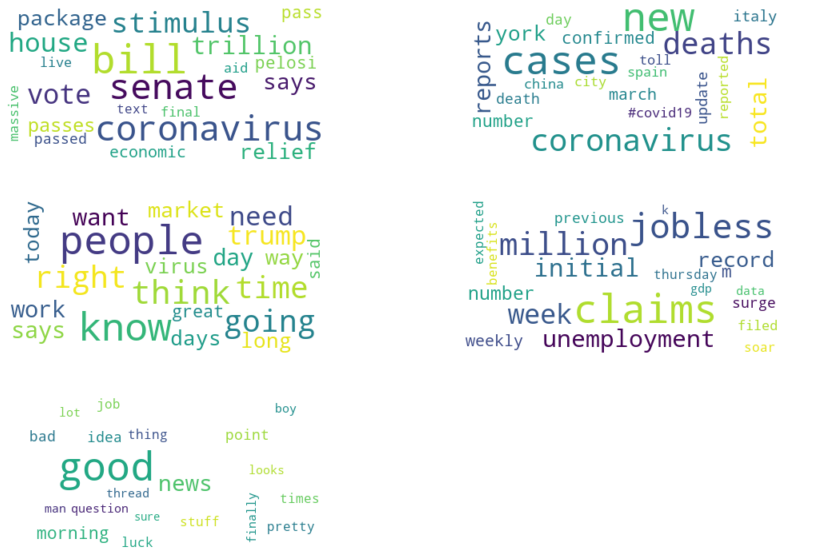

In [16]:
day = date_dict['2020-03-26']

def word_clouds(day):
    """
    Plot 5 word clouds for each day, top 20 words per each topic.
    Uses wordcloud library
    """
    print(dates[day])
    wc = WordCloud(max_font_size=50, contour_width=3, background_color='white')

    fig, ax = plt.subplots(3,2,figsize=(15,10))
    ax = ax.ravel()
    for i in range(5):
        wordcloud = wc.generate_from_frequencies({q:t for t, q in zip(top_proba_list[day][i],top_words_list[day][i])})
        ax[i].imshow(wordcloud, interpolation="bilinear")
        ax[i].axis("off")
    ax[5].axis("off");

word_clouds(day)

In [17]:

nlp_mid = spacy.load('en_core_web_md')

# Obtain GloVe representations for each of 20 words in each topic
# Estimate the mean of each set of 20 words
concat_words = [[' '.join(top_words) for top_words in sub_top_list] for sub_top_list in top_words_list]
word_vectors = [[nlp_mid(topic_words).vector for topic_words in concat_word] for concat_word in concat_words]

# Topic coherence is the average of all cosine similarities between each of 5 vectors for each topic
topic_coherence = []
# Topic coherence difference between day i and i+1
topic_coherence_diff = []

n_topics = 5
den = (n_topics**2-n_topics)
for i in range(len(word_vectors)-1):
    cs = cosine_similarity(word_vectors[i] + word_vectors[i+1])
    # Topic coherence
    tc = (cs[n_topics:2*n_topics,n_topics:2*n_topics].sum() \
        - cs[n_topics:2*n_topics,n_topics:2*n_topics].diagonal().sum())/den
    topic_coherence.append(tc)
    # Topic coherence difference between day i and i+1
    tcd = cs[0:n_topics,n_topics:2*n_topics].max(axis=1).mean()
    topic_coherence_diff.append(tcd) 

In [18]:
# Add features to nmf_features DataFrame
nmf_features = pd.DataFrame(index = dates[1:])
nmf_features['topic_coherence'] = topic_coherence
nmf_features['topic_coherence_diff'] = topic_coherence_diff
nmf_features['recon_ratio'] = np.array(model_err) / np.array(new_err)-1
nmf_features.index.rename('Date', inplace=True)

nmf_features.head()

,topic_coherence,topic_coherence_diff,recon_ratio
Date,,,
2020-02-03,0.669626,0.868886,0.005464
2020-02-04,0.655170,0.920279,0.001128
2020-02-05,0.659050,0.916028,0.003590
2020-02-06,0.645251,0.874288,0.002431
2020-02-07,0.633124,0.906188,0.005036


## Sentiment Features

In [ ]:
# sentiment-analysis uses model 'distilbert-base-uncased-finetuned-sst-2-english'
# https://huggingface.co/transformers/_modules/transformers/pipelines.html#TextClassificationPipeline

# device=0 if GPU, -1 if CPU
sentiment_model = pipeline('sentiment-analysis', device=0)

# clean_sentiment function removes links, hashtags, emails and @s from each tweet
tweet_df.tweet = clean_sentiment(tweet_df.tweet)

# create pandas DataFrame to store sentiment measure.
sentiment = tweet_df[['tweet_id','handle']].copy()
sentiment['sentiment'] = 0
sentiment['score'] = 0

In [ ]:
# Estimate sentiment per tweet. Output from sentiment model is a dictionary that indicates 'POSITIVE' or 'NEGATIVE'
# and probability of classification. Storing both in 'sentiment' and 'score' columns
# This can take a long time if no GPU!

t = time.time()
# Batch size of inputs to sentiment model
batch_size = 16
for i in range(0,len(tweet_df),batch_size):
    if i%10000 == 0:
        print("{}/{}, time {:.2f}".format(i, len(tweet_df),(time.time() - t)/60),end="\r")
    sentiment_dict = sentiment_model(tweet_df.tweet.iloc[i:i+batch_size].to_list())
    sentiment.sentiment.iloc[i:i+batch_size] = [1 if d['label'] == 'POSITIVE' else -1 for d in sentiment_dict]
    sentiment.score.iloc[i:i+batch_size] = [d['score'] for d in sentiment_dict]
    
print("{}/{}, time {:.2f}".format(i, len(tweet_df),(time.time() - t)/60),end="\r")

In [25]:
# Join with user class data

classi = pd.read_csv('data/handle_class.csv')
sentiment = pd.merge(sentiment,classi[['class','handle','subclass']],on=['handle'], right_index=True)
sentiment.head()

,tweet_id,handle,sentiment,score,class,subclass
timestamp,,,,,,
2006-09-22 09:02:46,33743,guan,1,0.999717,fintwit,opinion
2006-09-22 09:21:33,33745,guan,1,0.999805,fintwit,opinion
2007-03-08 12:50:52,5929557,guan,1,0.982900,fintwit,opinion
2007-04-06 16:29:24,20844701,guan,1,0.999859,fintwit,opinion
2007-04-07 14:01:37,21447221,guan,-1,0.999554,fintwit,opinion


In [ ]:
# Function to aggregate scores. Sentiment score is sentiment (1/-1 if positive/negative) * score (probability)
def final_score(x):
    return (x.sentiment * x.score).mean()

sentiment_features = pd.DataFrame(index = date_range[1:])
# Creating bins for groupby for dates with cutoff at 3:45
date_bins = pd.cut(sentiment.index, bins=date_range)

# Daily Average
sentiment_features['daily_average'] = sentiment.groupby(date_bins).apply(final_score)

#Average by user class
class_averages = sentiment.groupby([date_bins,'class']).apply(final_score).unstack().add_prefix('daily_average_')
sentiment_features[class_averages.columns] = class_averages
del class_averages

sentiment_features['daily_average_trader'] = sentiment.groupby([date_bins,'subclass']).apply(final_score)[:,'trader']

sentiment_features.head()

In [ ]:
#Counting number of tweets per day, num_tweets. 
#The quantity is number of tweets in a day divided by the 200 day moving average of tweets in a day
# Use MA since number of tweets has increased steadily over time
# Since a weekend or holiday counts as a "day", need to standardize
# Looking at the average number of tweets for 2, 3, 4, 5 days respectively 

A = pd.DataFrame(index = date_range[1:])
A['avg'] = sentiment.groupby(date_bins).agg('count').tweet_id
A['day_diff'] = 0
A.day_diff.loc[A.index[1:]] = (A.index[1:] - A.index[:-1]).days
for i in [2,3,4,5]:
    ratio = A[A.day_diff == 1].mean()/A[A.day_diff == i].mean()
    A.loc[A.day_diff == i, 'avg'] = (ratio['avg'] * A[A.day_diff == i]['avg']).astype('int')
A = A/A.rolling(200, min_periods=1).mean()
sentiment_features['num_tweets'] = A.avg
# First few days fix at 1 for moving average burn in
sentiment_features.num_tweets.iloc[0:7] = 1
# Cap num_tweets from below at 0.8. Any lower than this usually happens in December during holidays 
sentiment_features.loc[sentiment_features.num_tweets < 0.8,'num_tweets'] =0.8

In [ ]:
sentiment_features.Date = pd.to_datetime(sentiment_features.Date)
sentiment_features.Date = sentiment_features.Date.dt.date
sentiment_features.set_index('Date',drop=True, inplace=True)

es = pd.read_csv('data/spx.csv')
es.Date = pd.to_datetime(es.Date +' ' +'15:45')
es.set_index('Date', inplace=True)

es.index = es.index.date

In [ ]:
# Comparing sentiment to market performance. Taking 50D moving average to smooth out spikes

mkt = sentiment_features.daily_average.rolling(50).mean()
mkt2 = sentiment_features.daily_average_trader.rolling(50).mean()

fig, ax = plt.subplots(1,2,figsize=(15,6))
ax[0].plot(mkt, label='daily average')
ax[0].plot(mkt2, label='daily_average_trader')
ax[0].set_title('Daily Sentiment, 50 day MA')

ax[0].legend()

ax[1].plot(es.loc[mkt.index])
ax[1].set_title('S&P 500 futures');



In [ ]:
# Comparing sentiment to market performance during 2020. Taking 5D moving average to smooth out spikes

mkt = sentiment_features.daily_average.rolling(5).mean()
mkt2 = sentiment_features.daily_average_trader.rolling(5).mean()
mkt3 = sentiment_features.daily_average_news.rolling(5).mean()


fig, ax = plt.subplots(1,2,figsize=(15,6))
plt.xticks(rotation=90)
ax[0].plot(mkt[pd.to_datetime('2020-01-01'):pd.to_datetime('2020-05-01')], 
           label='daily average')
ax[0].plot(mkt2[pd.to_datetime('2020-01-01'):pd.to_datetime('2020-05-01')], 
           label='daily_average_trader')
ax[0].plot(mkt3[pd.to_datetime('2020-01-01'):pd.to_datetime('2020-05-01')], 
           label='daily_average_news')
ax[0].set_title('Daily Sentiment, 10 day MA')
ax[0].legend()
ax[0].tick_params(labelrotation=45)

ax[1].plot(es.loc[pd.to_datetime('2020-01-01'):pd.to_datetime('2020-05-01')])
ax[1].set_title('S&P 500 futures');
ax[1].tick_params(labelrotation=45)


In [ ]:
plt.plot(sentiment_features.num_tweets)
plt.title('Number of tweets ratio');

# Market

For this part I use the features calculated from the full data set

In [27]:
# Load market data
es = pd.read_csv('data/spx.csv')
es.Date = pd.to_datetime(es.Date)
es.set_index('Date', inplace=True)

# Calculate 1 day returns, and roll one day after to use as prediciton
es['return'] = np.roll(es['Close'].pct_change(),-1)
es = es.loc['2012-01-04':'2020-5-29']
es.head()

# Load sentiment and topic features
sentiment_features = pd.read_csv('data/sentiment_features.csv')
nmf_features = pd.read_csv('data/nmf_features.csv')

# Merge features
sentiment_features = sentiment_features.iloc[1:].reset_index(drop=True)
features = nmf_features.copy()
features.Date = pd.to_datetime(features.Date, dayfirst=True)
features.set_index('Date', inplace=True)
sentiment_features.index = features.index
features = sentiment_features.join(features).drop(['Date'],axis=1)
features.index = pd.to_datetime(features.index)
features.sort_index(inplace=True)

#features.drop(['daily_average_politics'],axis=1, inplace=True)
features.head()



,daily_average,daily_average_fintwit,daily_average_news,daily_average_politics,daily_average_trader,num_tweets,topic_coherence,topic_coherence_diff,recon_ratio
Date,,,,,,,,,
2012-01-04,-0.266243,-0.334767,-0.166645,-0.239557,-0.336303,1.0,0.744901,0.898953,0.002581
2012-01-05,-0.337371,-0.384344,-0.291280,-0.243320,-0.368697,1.0,0.644985,0.845906,0.004651
2012-01-06,-0.325877,-0.355626,-0.321614,-0.214214,-0.354338,1.0,0.729873,0.811649,0.005132
2012-01-09,-0.252546,-0.257554,-0.255376,-0.235941,-0.223905,1.0,0.670430,0.847776,0.009600
2012-01-10,-0.302168,-0.332257,-0.267115,-0.251730,-0.336150,1.0,0.686796,0.872777,0.002024


## Cross Validation

Cross validate max_depth for RandomForest and GradientBoostingClassifier    
Range of max_depth = 6-20  
Exclude low levels of max_depth to avoid the model always choosing same category  
Use ROC-AUC and logloss as measure. They yield same rankings 

In [31]:
# Cutoff for test set
date = '2018-12-31'

es_class = 1*(es['return'] >0)

X = features[:date]
y = es_class[:date]

# 5 fold time series split
# The Validation is done like this:
# TRAIN: [0] TEST: [1]
# TRAIN: [0 1] TEST: [2]
# TRAIN: [0 1 2] TEST: [3]
# TRAIN: [0 1 2 3] TEST: [4]
# TRAIN: [0 1 2 3 4] TEST: [5]

tscv= TimeSeriesSplit(n_splits=5)

logloss = pd.DataFrame(index = range(6,21), columns=['rf', 'boost'])
rocauc = pd.DataFrame(index = range(6,21), columns=['rf', 'boost'])

for max_depth in range(6,21):
    rf_logloss = []
    boost_logloss = []
    
    rf_rocauc = []
    boost_rocauc = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # Random Forest Classifier
        clf = RandomForestClassifier(max_depth=max_depth, criterion='entropy', random_state=42)
        clf.fit(X_train, y_train)
        rf_logloss.append(log_loss(clf.predict(X_test), y_test))
        rf_rocauc.append(roc_auc_score(clf.predict(X_test), y_test))
        # Gradient Boosting Classifier
        clf = GradientBoostingClassifier(max_depth=max_depth, random_state=42)
        clf.fit(X_train, y_train)
        boost_logloss.append(log_loss(clf.predict(X_test), y_test))
        boost_rocauc.append(roc_auc_score(clf.predict(X_test), y_test))
        
    logloss.loc[max_depth, 'rf'] = np.mean(rf_logloss)
    logloss.loc[max_depth, 'boost'] = np.mean(boost_logloss)
    
            
    rocauc.loc[max_depth, 'rf'] = np.mean(rf_rocauc)
    rocauc.loc[max_depth, 'boost'] = np.mean(boost_rocauc)



In [32]:
# Max reached at max_depth=15 for Random Forest, max_depth=9 for Boost
logloss

,rf,boost
6,16.4358,16.8884
7,16.4596,17.079
8,16.412,16.9599
9,16.6978,16.3644
10,16.5072,17.1028
11,16.7931,17.0313
12,16.5787,17.1504
13,17.0789,17.2696
14,16.412,17.4601
15,16.3882,17.1505


In [33]:
# Max reached at max_depth=15 for Random Forest, max_depth=9 for Boost
rocauc

,rf,boost
6,0.5072,0.496931
7,0.508627,0.490514
8,0.501226,0.491492
9,0.4941,0.513954
10,0.499638,0.488901
11,0.48585,0.497096
12,0.500237,0.489257
13,0.478843,0.488558
14,0.506507,0.483274
15,0.510174,0.492765


## Performance Analysis

In [34]:
def sharpe_ratio(pos, ret):
    # Mean of returns divided by standard deviation of returns, annualized
    return np.sqrt(252) * ( pos * ret ).mean() / ( pos * ret ).std()

# Two strategies: 
# One: If model predicts up move, buy S&P500 at close, if it predicts down move, flat
# Two: If model predicts up move, buy S&P500 at close, if it predicts down move, short S&P500 at close

# Sharpe for each fold for strategy One/Two
rf_sharpe = []
rf_short_sharpe = []

boost_sharpe = []
boost_short_sharpe = []

# direction * return for each day for strategy One/Two
rf_pos = []
rf_pos_short = []

boost_pos = []
boost_pos_short = []

# Up.down prediction for each day
rf_position = []
boost_position = []

# Sharpe for SPX
es_sharpe = []

# Collecting stats for each training fold for the best model found

X = features[:date]
y = es_class[:date]

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    es_sharpe.append(sharpe_ratio(1,es['return'][test_index]))
    
    clf = RandomForestClassifier(max_depth=15, criterion='entropy',random_state= 42)
    clf.fit(X_train, y_train)
    rf_sharpe.append(sharpe_ratio(clf.predict(X_test), es['return'][test_index]))
    rf_short_sharpe.append(sharpe_ratio((2 * clf.predict(X_test) - 1), es['return'][test_index]))
    rf_pos.append(clf.predict(X_test)*es['return'][test_index])
    rf_position.append(clf.predict(X_test))
    rf_pos_short.append((2 * clf.predict(X_test) - 1)*es['return'][test_index])
    
    clf = GradientBoostingClassifier(max_depth=9,random_state= 42)
    clf.fit(X_train, y_train)
    boost_sharpe.append(sharpe_ratio(clf.predict(X_test), es['return'][test_index]))
    boost_short_sharpe.append(sharpe_ratio((2 * clf.predict(X_test) - 1), es['return'][test_index]))
    boost_pos.append(clf.predict(X_test)*es['return'][test_index])
    boost_position.append(clf.predict(X_test))
    boost_pos_short.append((2 * clf.predict(X_test) - 1)*es['return'][test_index])

# Collecting stats for the test set for the best model found
    
X_train = features[:date]
X_test = features[date:]

y = 1*(es['return'] >0)

y_train = y[:date]
y_test = y[date:]

es_sharpe.append(sharpe_ratio(1,es['return'][date:]))

clf = RandomForestClassifier(max_depth=15, criterion='entropy',random_state= 42)
clf.fit(X_train, y_train)
rf_sharpe.append(sharpe_ratio(clf.predict(X_test), es['return'][date:]))
rf_short_sharpe.append(sharpe_ratio((2 * clf.predict(X_test) - 1), es['return'][date:]))
rf_pos.append(clf.predict(X_test)*es['return'][date:])
rf_pos_short.append((2 * clf.predict(X_test) - 1)*es['return'][date:])
rf_position.append(clf.predict(X_test))
    
clf = GradientBoostingClassifier(max_depth=9,random_state= 42)
clf.fit(X_train, y_train)
boost_sharpe.append(sharpe_ratio(clf.predict(X_test), es['return'][date:]))
boost_short_sharpe.append(sharpe_ratio((2 * clf.predict(X_test) - 1), es['return'][date:]))
boost_pos.append(clf.predict(X_test)*es['return'][date:])
boost_pos_short.append((2 * clf.predict(X_test) - 1)*es['return'][date:])
boost_position.append(clf.predict(X_test))


rf_pos = pd.concat(rf_pos)
rf_pos_short = pd.concat(rf_pos_short)
rf_position = np.concatenate(rf_position)

boost_pos = pd.concat(boost_pos)
boost_pos_short = pd.concat(boost_pos_short)
boost_position = np.concatenate(boost_position)


# Stats for both strategies
# Strategy One is Long, Strategy Two is Short
# Accuracy, F1-Score, Sharpe for full period, Sharpe for Test Set, % of days with a position

Stats = pd.DataFrame(index=['SPX','RF','GradBoost'],
            columns=['Accuracy', 
                     'F1', 
                     'Sharpe Long Total', 
                     'Sharpe Short Total', 
                     'Sharpe Long Test', 
                     'Sharpe Short Test', 
                     'Days Long'])

fold_0_ind = 291

Stats.loc['SPX','Accuracy'] = accuracy_score(y.iloc[fold_0_ind:]*0 + 1, y.iloc[fold_0_ind:])
Stats.loc['RF', 'Accuracy'] = accuracy_score(rf_position, y.iloc[fold_0_ind:])
Stats.loc['GradBoost', 'Accuracy'] = accuracy_score(boost_position, y.iloc[fold_0_ind:])

Stats.loc['SPX','F1'] = ''
Stats.loc['RF', 'F1'] = f1_score(rf_position, y.iloc[fold_0_ind:])
Stats.loc['GradBoost', 'F1'] = f1_score(boost_position, y.iloc[fold_0_ind:])

Stats.loc['SPX','Sharpe Long Total'] = sharpe_ratio(1,es.iloc[fold_0_ind:]['return'])
Stats.loc['RF', 'Sharpe Long Total'] = sharpe_ratio(1,rf_pos)
Stats.loc['GradBoost', 'Sharpe Long Total'] = sharpe_ratio(1,boost_pos)


Stats.loc['SPX','Sharpe Short Total'] = sharpe_ratio(1,es.iloc[fold_0_ind:]['return'])
Stats.loc['RF', 'Sharpe Short Total'] = sharpe_ratio(1,rf_pos_short)
Stats.loc['GradBoost', 'Sharpe Short Total'] = sharpe_ratio(1,boost_pos_short)

Stats.loc['SPX','Sharpe Long Test'] = es_sharpe[-1]
Stats.loc['RF', 'Sharpe Long Test'] = rf_sharpe[-1]
Stats.loc['GradBoost', 'Sharpe Long Test'] = boost_sharpe[-1]

Stats.loc['SPX','Sharpe Short Test'] = es_sharpe[-1]
Stats.loc['RF', 'Sharpe Short Test'] = rf_short_sharpe[-1]
Stats.loc['GradBoost', 'Sharpe Short Test'] = boost_short_sharpe[-1]


Stats.loc['SPX', 'Days Long'] = 1
Stats.loc['RF', 'Days Long'] = rf_position.sum()/len(rf_position)
Stats.loc['GradBoost', 'Days Long'] = boost_position.sum()/len(boost_position)

Stats

,Accuracy,F1,Sharpe Long Total,Sharpe Short Total,Sharpe Long Test,Sharpe Short Test,Days Long
SPX,0.549085,,0.69096,0.69096,0.629522,0.629522,1
RF,0.544648,0.646882,0.809364,0.707095,1.34748,1.62605,0.740433
GradBoost,0.520244,0.600831,0.595086,0.254204,0.797615,0.561864,0.652801


Random Forest beats SPX and Gradboost in both the Long and Long/Short strategy


### Feature Importances

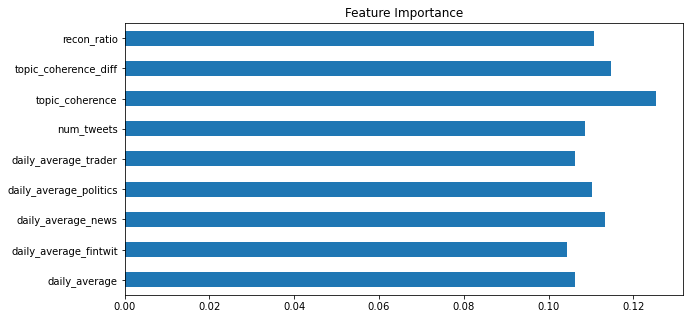

In [35]:
date = '2018-12-31'

X_train = features[:date]
X_test = features[date:]

y = 1*(es['return'] >0)

y_train = y[:date]
y_test = y[date:]

clf = RandomForestClassifier(max_depth=15, random_state=42)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)


CCC = pd.DataFrame(columns=['feature_importances'], index = X_train.columns)
CCC['feature_importances'] = clf.feature_importances_
CCC.plot.barh(figsize=(10,5), legend=False, title="Feature Importance");
